# Análise de desempenho estudantil com KMeans

## Objetivo

O dataset utilizado foi extraído dos históricos acadêmicos do Sistema Integrado de Gestões Acadêmicas. Ele servirá como base para a clusterização de estudantes, considerando seus índices de aprovação e reprovação no 1º e 2º períodos. O objetivo desse processo é identificar padrões de desempenho presentes em cada cluster e, a partir disso, gerar insights que possibilitem o desenvolvimento de ações e políticas mais eficazes para cada grupo de alunos.

## Algoritmo

### Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.cluster import KMeans

### Carregamento de dados

In [ ]:
alunos = pd.read_csv('1o_2o_periodo.csv')

A análise será conduzida de forma mais simples, pois as notas serão convertidas para um formato binário: 1 para aprovado e 0 para reprovado

In [ ]:
# features (matérias)
features = ["IM885", "IM853", "TN707", "TN705", "TN706", "TN703",
            "IM429", "IM403", "TN711", "TN709", "TN712", "TN710"]

### Centroids

In [ ]:
# função p/ gerar os centroids aleatórios
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample().iloc[0]))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

### Cálculo de distância + atribuindo labels

In [ ]:
def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [ ]:
# função para calcular novos centroides
def new_centroids(data, labels, k):
    centroids = []
    for i in range(k):
        cluster_data = data[labels == i]
        if len(cluster_data) > 0:
            # usar média aritmética
            centroid = cluster_data.mean()
        else:
            # caso o cluster esteja vazio, manter o centroide anterior ou gerar aleatório
            centroid = data.sample(1).iloc[0]
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

## Escolha de parâmetros

Escolhi a técnica PCA para reduzir as dimensões e o Elbow Method para inferir o melhor valor para K.

In [ ]:
def plot_clusters(data, labels, centroids, iteration):

  # PCA
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)

    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.title(f'Iteration {iteration}')
    scatter = plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1], c='red', marker='X', s=200, edgecolors='black')
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()


--- cotovelo ---


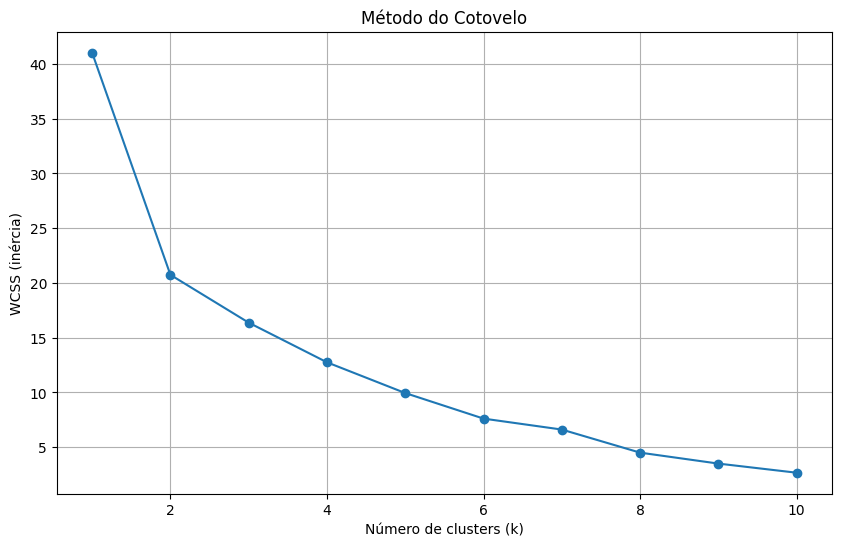

melhor valor para k: 3


/tmp/ipython-input-2608143952.py:26: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(b-a, a-p)) / np.linalg.norm(b-a)


In [ ]:

# cotovelo
def elbow_method_sklearn(data, k_min=1, k_max=10):
    wcss = []
    ks = range(k_min, k_max+1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, wcss, marker='o')
    plt.title('Método do Cotovelo')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('WCSS (inércia)')
    plt.grid(True)
    plt.show()

    return list(ks), wcss

def best_k(ks, wcss):
    p1 = np.array([ks[0], wcss[0]])
    p2 = np.array([ks[-1], wcss[-1]])

    def dist(p, a, b):
        return np.abs(np.cross(b-a, a-p)) / np.linalg.norm(b-a)

    dists = [dist(np.array([ks[i], wcss[i]]), p1, p2) for i in range(len(ks))]
    return ks[int(np.argmax(dists))]

print("\n--- cotovelo ---")
ks, wcss = elbow_method_sklearn(data, k_min=1, k_max=10)
melhor_k = best_k(ks, wcss)
print(f"melhor valor para k: {melhor_k}")

## KMeans com o melhor K

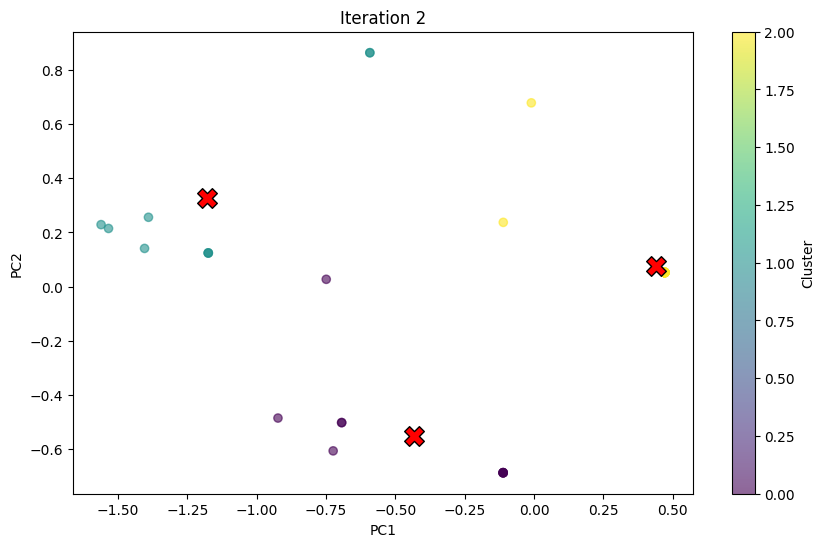

In [ ]:
max_iterations = 100
centroid_count = melhor_k

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

print(f"centroids iniciais:\n{centroids}\n")

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids.copy()

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, centroid_count)

    # p/verificar a distribuição dos clusters
    cluster_sizes = labels.value_counts().sort_index()
    print(f"Iteração {iteration}: {dict(cluster_sizes)}")

    if iteration % 10 == 0 or iteration == 1:
        plot_clusters(data, labels, centroids, iteration)

    iteration += 1

print(f"\nconvergiu em {iteration-1} iterações")
print(f"\ndistribuição final dos clusters:")
print(labels.value_counts().sort_index())

# Plotar resultado final
plot_clusters(data, labels, centroids, iteration-1)

In [ ]:
print("\n--- ANÁLISE DOS CLUSTERS ---")
for cluster_id in sorted(unique_labels):
    cluster_data = data[labels == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Tamanho: {len(cluster_data)} alunos")
    print(f"  Taxa média de aprovação: {cluster_data.mean().mean():.2%}")
    print(f"  Matérias com maior taxa de aprovação:")
    top_subjects = cluster_data.mean().sort_values(ascending=False).head(3)
    for subject, rate in top_subjects.items():
        print(f"    {subject}: {rate:.2%}")


--- ANÁLISE DOS CLUSTERS ---

Cluster 0:
  Tamanho: 10 alunos
  Taxa média de aprovação: 85.00%
  Matérias com maior taxa de aprovação:
    IM885: 100.00%
    IM853: 100.00%
    TN707: 100.00%

Cluster 1:
  Tamanho: 9 alunos
  Taxa média de aprovação: 69.44%
  Matérias com maior taxa de aprovação:
    IM853: 100.00%
    TN707: 100.00%
    TN709: 100.00%

Cluster 2:
  Tamanho: 34 alunos
  Taxa média de aprovação: 99.51%
  Matérias com maior taxa de aprovação:
    IM885: 100.00%
    IM853: 100.00%
    TN707: 100.00%


# Conclusões

### Matérias

As matérias IM853, IM885 e TN707 são universais em alta aprovação, sugerindo serem mais “fáceis”. Já algumas disciplinas (como TN706, IM403, TN712) apresentam variação e são discriminativas nos clusters.

### Limitações

Utilizar somente notas não é o suficiente para uma análise aprofundada. As conclusões seriam mais robustas se fossem considerados outros fatores determinantes que não estavam presentes no dataset original, como carga horária de trabalho, perfil socioeconômico, frequência às aulas, entre outros

### Políticas e intervenções

**Cluster 1 - Alunos de Alto Desempenho (33 alunos, 99,75%)**

Características:

* Altíssima taxa de aprovação (quase 100%).
* Desempenho superior à média em quase todas as disciplinas.
* Baixa variância interna — grupo homogêneo.


Propostas de políticas para este cluster
* Programa de talentos acadêmicos
* Incentivar que os alunos desse grupo se tornem monitores, pois têm facilidade e com isso podem auxiliar alunos de outros grupos.
formação de grupos avançados de estudo

**Cluster 2 — Alunos de Bom Desempenho, com Fragilidades Pontuais (7 alunos, 82,14%)**

Características:
* A maioria das disciplinas tem boas taxas de aprovação.
* Há algumas disciplinas específicas que debilitam esse grupo.
* O padrão sugere dificuldades não sistemáticas, talvez isoladas.

Propostas de políticas para este cluster:
* Criar grupos de reforço para matérias com baixo grau de aprovação (Como TN706)
* Exercícios extras e revisões antes das provas.
* Workshops de temas multidisciplinares, como técnicas de estudo, gestão de tempo, etc.

**Cluster 0 — Grupo de Risco Moderado (13 alunos, 76,28%)**

Características:

* Menor taxa média de aprovação.

* Desempenho inconsistente entre disciplinas.

* Possivelmente o grupo com maior risco de retenção ou evasão.


Propostas de políticas para este cluster:

* Programa de acompanhamento intensivo para prevenir a reprovação:
  * com check-ins periódicos com a coordenação,
  * monitoria (possívelmente com os alunos do Cluster 1)
* Identificar lacunas em matemática, lógica, programação.
